In [86]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [87]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-04-17 19:03:43--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.09s   

2021-04-17 19:03:44 (246 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [88]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [89]:
df.shape

(346, 10)

### Convert to date time object 

In [90]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



In [91]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


In [92]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

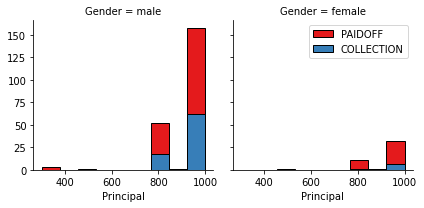

In [93]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

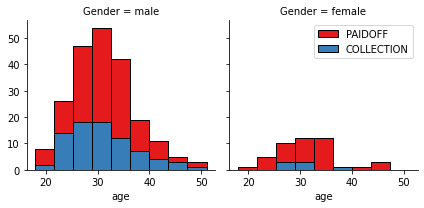

In [94]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

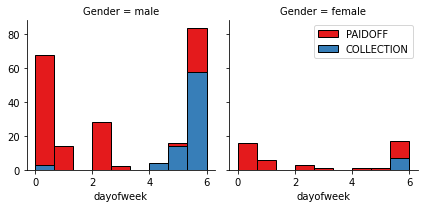

In [95]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [96]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [97]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [98]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [99]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [100]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [101]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [102]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [103]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

In [104]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

# K Nearest Neighbor(KNN)


In [105]:
#Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [106]:
#Training
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 12
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMtx=[];
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.74285714, 0.71428571, 0.77142857, 0.74285714, 0.78571429,
       0.75714286, 0.87142857, 0.77142857, 0.77142857, 0.77142857,
       0.78571429])

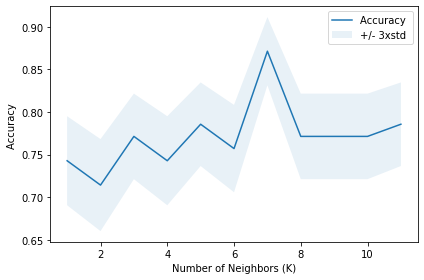

The best accuracy was with 0.8714285714285714 with k= 7


In [107]:
plt.plot(range(1,Ks),mean_acc)
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

neigh = KNeighborsClassifier(n_neighbors=mean_acc.argmax()+1).fit(X_train, y_train)

In [108]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)



The best accuracy was with 0.8714285714285714 with k= 7


In [109]:
# Set value of k as 7
k = 7
# Train Model and Predict  
loanknn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
loanknn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [110]:
yhat = loanknn.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

In [111]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loanknn.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7681159420289855
Test set Accuracy:  0.8714285714285714


In [112]:
from sklearn.metrics import classification_report

print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

  COLLECTION       0.67      0.50      0.57        12
     PAIDOFF       0.90      0.95      0.92        58

    accuracy                           0.87        70
   macro avg       0.78      0.72      0.75        70
weighted avg       0.86      0.87      0.86        70



In [113]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

0.8638655462184873

In [114]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.8714285714285714

# Decision Tree

In [115]:
# Import the decision tree model

from sklearn.tree import DecisionTreeClassifier

In [116]:
md = 10
mean_acc = np.zeros((md-1))
std_acc = np.zeros((md-1))
ConfustionMx = [];
for n in range(1,md):
    
    #Train Model and Predict  
    loant = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    yhat=loant.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.82857143, 0.82857143, 0.82857143, 0.74285714, 0.75714286,
       0.72857143, 0.75714286, 0.68571429, 0.74285714])

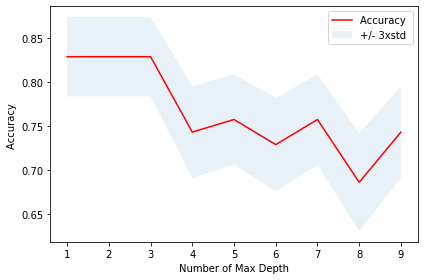

In [117]:
plt.plot(range(1,md),mean_acc,'r')
plt.fill_between(range(1,md),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Max Depth')
plt.tight_layout()
plt.show()

In [118]:
#Building the decision tree with max depth of 6
loandt = DecisionTreeClassifier(criterion="entropy", max_depth = 6)

# Check the default parameters
loandt 

# Train the Decision tree model
loandt.fit(X_train,y_train)

# Predict using the model
yhat= loandt.predict(X_test)

In [119]:
#Calculating the train and test accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loandt.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
#Building the confusion matrix
print (classification_report(y_test, yhat))

Train set Accuracy:  0.7789855072463768
Test set Accuracy:  0.7285714285714285
              precision    recall  f1-score   support

  COLLECTION       0.29      0.42      0.34        12
     PAIDOFF       0.87      0.79      0.83        58

    accuracy                           0.73        70
   macro avg       0.58      0.60      0.59        70
weighted avg       0.77      0.73      0.75        70



In [120]:
# Calculate the F1 score
f1_score(y_test, yhat, average='weighted')

0.7458571872364976

In [121]:
# Calculate the jaccard index
jaccard_similarity_score(y_test, yhat)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.7285714285714285

In [122]:
#Visualize the Decison tree
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

In [123]:
'''from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline '''

'from sklearn.externals.six import StringIO\nimport pydotplus\nimport matplotlib.image as mpimg\nfrom sklearn import tree\n%matplotlib inline '

In [124]:
'''dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(loandt,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')'''

'dot_data = StringIO()\nfilename = "loantree.png"\nfeatureNames = Feature.columns\ntargetNames = df[\'loan_status\'].unique().tolist()\nout=tree.export_graphviz(loandt,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  \ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \ngraph.write_png(filename)\nimg = mpimg.imread(filename)\nplt.figure(figsize=(100, 200))\nplt.imshow(img,interpolation=\'nearest\')'

# Support Vector Machine

In [125]:
# Import the library for SVM Classifier
from sklearn import svm

# Build a SVM Classifier with a Radial base Function Kernel
loansvm1 = svm.SVC(kernel='rbf').fit(X_train, y_train)
yhat1 = loansvm1.predict(X_test)
svm_r = metrics.accuracy_score(y_test, yhat1)

# Build a SVM Classifier with a Linear Kernel
loansvm2 = svm.SVC(kernel='linear').fit(X_train, y_train)
yhat2 = loansvm2.predict(X_test)
svm_l = metrics.accuracy_score(y_test, yhat2)
    
# Build a SVM Classifier with a Polynomial Kernel
loansvm3 = svm.SVC(kernel='poly').fit(X_train, y_train)
yhat3 = loansvm3.predict(X_test)
svm_p = metrics.accuracy_score(y_test, yhat3)

# Build a SVM Classifier with a Sigmoid Kernel
loansvm4 = svm.SVC(kernel='sigmoid').fit(X_train, y_train)
yhat4 = loansvm4.predict(X_test)
svm_s = metrics.accuracy_score(y_test, yhat4)
    
print(svm_r,svm_l,svm_p,svm_s)

0.8142857142857143 0.8285714285714286 0.8285714285714286 0.8


In [126]:
# Find if labels are missing in the SVM models 
print("The label missing in the first model with rbf kernel",set(y_test) - set(yhat1))
print("The label missing in the second model with linear",set(y_test) - set(yhat2))
print("The label missing in the third model with polynomial kernel",set(y_test) - set(yhat3))
print("The label missing in the fourth model with sigmoid kernel",set(y_test) - set(yhat4))

The label missing in the first model with rbf kernel set()
The label missing in the second model with linear {'COLLECTION'}
The label missing in the third model with polynomial kernel set()
The label missing in the fourth model with sigmoid kernel set()


In [127]:
#The SVM with the Radial base function and sigmoid kernel have the same accuracy (74.28%) and the models predicted the value collection as well, we conclude the that the rbf kernel is the best
#SVM Classifier with Radial base function kernel
# Build and train the SVM Classifier with a linear kernel

loansvm = svm.SVC(kernel='rbf').fit(X_train, y_train)

In [128]:
#Predicting the test values using the SVM model
yhat = loansvm.predict(X_test)
yhat [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [129]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loansvm.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

print (classification_report(y_test, yhat))

Train set Accuracy:  0.7644927536231884
Test set Accuracy:  0.8142857142857143
              precision    recall  f1-score   support

  COLLECTION       0.40      0.17      0.24        12
     PAIDOFF       0.85      0.95      0.89        58

    accuracy                           0.81        70
   macro avg       0.62      0.56      0.56        70
weighted avg       0.77      0.81      0.78        70



In [130]:
# Calculate the f1 score
f1_score(y_test, yhat, average='weighted')

0.7813349730135957

In [131]:
#Calculate the Jaccard index
jaccard_similarity_score(y_test, yhat)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.8142857142857143

# Logistic Regression

In [132]:
# Import the library for Logistice regression
from sklearn.linear_model import LogisticRegression

# Build and train the logestic regression model
loanlr1 = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat1 = loanlr1.predict(X_test)
loanlr_a1 = metrics.accuracy_score(y_test, yhat1)

# Build and train the logestic regression model
loanlr2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat2 = loanlr2.predict(X_test)
loanlr_a2 = metrics.accuracy_score(y_test, yhat2)

# Build and train the logestic regression model
loanlr3 = LogisticRegression(C=0.01, solver='saga').fit(X_train,y_train)
yhat3 = loanlr3.predict(X_test)
loanlr_a3 = metrics.accuracy_score(y_test, yhat3)

# Build and train the logestic regression model
loanlr4 = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)
yhat4 = loanlr4.predict(X_test)
loanlr_a4 = metrics.accuracy_score(y_test, yhat4)

# Build and train the logestic regression model
loanlr5 = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
yhat5 = loanlr5.predict(X_test)
loanlr_a5 = metrics.accuracy_score(y_test, yhat5)


print('LR model with liblinear solver',loanlr_a1)
print('LR model with sag solver',loanlr_a2)
print('LR model with saga solver',loanlr_a3)
print('LR model with newton-cg solver',loanlr_a4)
print('LR model with lbfgs solver',loanlr_a5)

LR model with liblinear solver 0.7857142857142857
LR model with sag solver 0.8285714285714286
LR model with saga solver 0.8285714285714286
LR model with newton-cg solver 0.8285714285714286
LR model with lbfgs solver 0.8285714285714286


In [133]:
# Find if labels are missing in the models 
print("The label missing in the LR model with liblinear solver",set(y_test) - set(yhat1))
print("The label missing in the LR model with sag solver",set(y_test) - set(yhat2))
print("The label missing in the LR model with saga solver",set(y_test) - set(yhat3))
print("The label missing in the LR model with newton-cg solver",set(y_test) - set(yhat4))
print("The label missing in the LR model with lbfgs solver",set(y_test) - set(yhat5))

The label missing in the LR model with liblinear solver set()
The label missing in the LR model with sag solver {'COLLECTION'}
The label missing in the LR model with saga solver {'COLLECTION'}
The label missing in the LR model with newton-cg solver {'COLLECTION'}
The label missing in the LR model with lbfgs solver {'COLLECTION'}


In [134]:
#Except for the liblinear solver all other model has skipped the lable "collection" from the predicted values. Hence, the best logistic classifier will be the one with a liblinear solver
loanlr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = loanlr.predict(X_test)

In [135]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loanlr.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print (classification_report(y_test, yhat))

Train set Accuracy:  0.7210144927536232
Test set Accuracy:  0.7857142857142857
              precision    recall  f1-score   support

  COLLECTION       0.20      0.08      0.12        12
     PAIDOFF       0.83      0.93      0.88        58

    accuracy                           0.79        70
   macro avg       0.52      0.51      0.50        70
weighted avg       0.72      0.79      0.75        70



In [136]:
# Calculate the f1 score
f1_score(y_test, yhat, average='weighted')

0.747694199631072

In [137]:
#Calculate the Jaccard index
jaccard_similarity_score(y_test, yhat)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.7857142857142857

# Model Evaluation using Test set

In [138]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

### Load Test set for evaluation 

In [139]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-04-17 19:03:47--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-04-17 19:03:48 (777 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [142]:
# shape of the test data set 
df.shape

(346, 12)

In [144]:
# Count of the loan status 
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [ ]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

df.groupby(['education'])['loan_status'].value_counts(normalize=True)

Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X_test = Feature

y_test = df['loan_status'].values

X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

In [147]:
# KNN model testing
yhat_knn = loanknn.predict(X_test)

# Calculate the f1 score
f1_knn = f1_score(y_test, yhat_knn, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_knn = jaccard_similarity_score(y_test, yhat_knn)

print('f1 score: ',f1_knn)
print('Jaccard index: ',jsc_knn)

f1 score:  0.8638655462184873
Jaccard index:  0.8714285714285714


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [148]:
# Predict using the model
yhat_dt= loandt.predict(X_test)

# Calculate the f1 score
f1_dt = f1_score(y_test, yhat_dt, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_dt = jaccard_similarity_score(y_test, yhat_dt)

print('f1 score: ',f1_dt)
print('Jaccard index: ',jsc_dt)

f1 score:  0.7458571872364976
Jaccard index:  0.7285714285714285


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [149]:
# Predict using the model
yhat_svm = loansvm.predict(X_test)

# Calculate the f1 score
f1_svm = f1_score(y_test, yhat_svm, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_svm = jaccard_similarity_score(y_test, yhat_svm)

print('f1 score: ',f1_svm)
print('Jaccard index: ',jsc_svm)

f1 score:  0.7813349730135957
Jaccard index:  0.8142857142857143


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [151]:
# Predict using the model
yhat_lr = loanlr.predict(X_test)

# Calculate the f1 score
f1_lr = f1_score(y_test, yhat_lr, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_lr = jaccard_similarity_score(y_test, yhat_lr)

# Calculate Log loss
yhat_lr_prob = loanlr.predict_proba(X_test)
ll_lr = log_loss(y_test, yhat_lr_prob)


print('f1 score: ',f1_lr)
print('Jaccard index: ',jsc_lr)
print('Log Loss: ',ll_lr)

f1 score:  0.747694199631072
Jaccard index:  0.7857142857142857
Log Loss:  0.5371534631623113


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [152]:
Jaccard = [jsc_knn,jsc_dt,jsc_svm,jsc_lr]
F1_score = [f1_knn,f1_dt,f1_svm,f1_lr]
LogLoss = ['NA','NA','NA',ll_lr]

    
df = {'Algorithm': ['KNN', 'Decistion Tree', 'SVM', 'LogisticRegression'], \
     'Jaccard': Jaccard, 'F1-score': F1_score, 'LogLoss': LogLoss}

Report = pd.DataFrame(data=df, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss'], index=None)
Report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.871429,0.863866,NA
1,Decistion Tree,0.728571,0.745857,NA
2,SVM,0.814286,0.781335,NA
3,LogisticRegression,0.785714,0.747694,0.537153
